In [47]:
import sys
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append('../bin')
from bin.functions import *
np.seterr(divide = 'ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df_res = pd.read_csv("all_result.csv", index_col=0)
df_res

,V1,perm_ent3,perm_ent4,mse,mape,sym_test,w_perm_ent4,smape,mase,max_diff,amplitude,mean,variance,adf_test_pvalue,kpss_test_pvalue
0,Y1,0.697843,0.539401,4993.838193,0.009190,False,-0.000000,0.009146,0.600416,232.30,2566.80,6523.738710,7.535744e+05,0.113077,0.010000
1,Y2,0.816579,0.705971,12899.948420,0.084814,False,-0.000000,0.088896,0.552155,599.00,1533.00,1346.387097,1.432428e+05,0.110802,0.096658
2,Y3,0.000000,0.000000,3476.611770,0.005390,False,-0.000000,0.005387,0.254877,320.00,5620.00,5595.806452,2.732452e+06,0.951878,0.010000
3,Y4,0.166740,0.144179,16100.535285,0.010972,False,-0.000000,0.010918,0.510635,440.00,6290.00,6599.032258,3.248222e+06,0.988328,0.010000
4,Y5,0.478736,0.395644,10617.608987,0.010394,False,-0.000000,0.010289,0.436703,590.00,4860.00,4012.580645,1.727553e+06,0.997930,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,D4223,NaN,0.907049,33883.253502,0.051424,True,0.175517,0.052152,3.794788,86.00,7097.00,3312.858131,1.695250e+05,0.000000,0.062011
4223,D4224,NaN,0.933608,1112.812688,0.007694,True,0.572596,0.007734,0.500734,195.00,6417.00,4104.727642,1.772440e+05,0.000000,0.100000
4224,D4225,NaN,0.910326,1858.370496,0.007457,False,0.552355,0.007506,0.022866,238.00,348148.00,5449.449057,4.566552e+08,0.497741,0.100000
4225,D4226,NaN,0.946536,27.140520,0.003027,True,0.666145,0.003028,0.340748,282.71,3823.38,1606.119072,8.195809e+05,0.515162,0.010000


In [3]:
ts_info = pd.read_csv("../src/M4-methods/Dataset/M4-info.csv")
ts_info

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


In [5]:
mse_list = pd.DataFrame([[0,0,0,0,0] for i in range(12)], ['Demographic','Demographic_sym', 'Finance','Finance_sym', 'Industry','Industry_sym', 'Macro','Macro_sym', 'Micro','Micro_sym', 'Other','Other_sym'], ['mean', 'q1', 'q3', 'ci_low','ci_high'])
smape_list = pd.DataFrame([[0,0,0,0,0] for i in range(12)], ['Demographic','Demographic_sym', 'Finance','Finance_sym', 'Industry','Industry_sym', 'Macro','Macro_sym', 'Micro','Micro_sym', 'Other','Other_sym'], ['mean', 'q1', 'q3', 'ci_low','ci_high'])
mase_list = pd.DataFrame([[0,0,0,0,0] for i in range(12)], ['Demographic','Demographic_sym', 'Finance','Finance_sym', 'Industry','Industry_sym', 'Macro','Macro_sym', 'Micro','Micro_sym', 'Other','Other_sym'], ['mean', 'q1', 'q3', 'ci_low','ci_high'])

In [6]:
def count_statisctic(ts, type):
    symmetry_ts = ts.loc[ts['sym_test']]
    not_symmetry_ts = ts.loc[ts['sym_test'] == False]
    mean = np.mean(not_symmetry_ts['mse'])
    q1 = np.percentile(not_symmetry_ts['mse'], 25)
    q3 = np.percentile(not_symmetry_ts['mse'], 75)
    ci_low, ci_high = np.percentile(not_symmetry_ts['mse'], [2.5, 97.5])
    mse_list.loc[type] = [mean, q1, q3, ci_low, ci_high]
    mean = np.mean(symmetry_ts['mse'])
    q1 = np.percentile(symmetry_ts['mse'], 25)
    q3 = np.percentile(symmetry_ts['mse'], 75)
    ci_low, ci_high = np.percentile(symmetry_ts['mse'], [2.5, 97.5])
    mse_list.loc[type+"_sym"] = [mean, q1, q3, ci_low, ci_high]
    mean = np.mean(not_symmetry_ts['smape'])
    q1 = np.percentile(not_symmetry_ts['smape'], 25)
    q3 = np.percentile(not_symmetry_ts['smape'], 75)
    ci_low, ci_high = np.percentile(not_symmetry_ts['smape'], [2.5, 97.5])
    smape_list.loc[type] = [mean, q1, q3, ci_low, ci_high]
    mean = np.mean(symmetry_ts['smape'])
    q1 = np.percentile(symmetry_ts['smape'], 25)
    q3 = np.percentile(symmetry_ts['smape'], 75)
    ci_low, ci_high = np.percentile(symmetry_ts['smape'], [2.5, 97.5])
    smape_list.loc[type+"_sym"] = [mean, q1, q3, ci_low, ci_high]
    mean = np.mean(not_symmetry_ts['mase'])
    q1 = np.percentile(not_symmetry_ts['mase'], 25)
    q3 = np.percentile(not_symmetry_ts['mase'], 75)
    ci_low, ci_high = np.percentile(not_symmetry_ts['mase'], [2.5, 97.5])
    mase_list.loc[type] = [mean, q1, q3, ci_low, ci_high]
    mean = np.mean(symmetry_ts['mase'])
    q1 = np.percentile(symmetry_ts['mase'], 25)
    q3 = np.percentile(symmetry_ts['mase'], 75)
    ci_low, ci_high = np.percentile(symmetry_ts['mase'], [2.5, 97.5])
    mase_list.loc[type+"_sym"] = [mean, q1, q3, ci_low, ci_high]

In [9]:
ts_macro = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Macro"]["M4id"].values)]
count_statisctic(ts_macro, "Macro")
ts_demog = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Demographic"]["M4id"].values)]
count_statisctic(ts_demog, "Demographic")
ts_finance = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Finance"]["M4id"].values)]
count_statisctic(ts_finance, "Finance")
ts_industry = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Industry"]["M4id"].values)]
count_statisctic(ts_industry, "Industry")
ts_micro = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Micro"]["M4id"].values)]
count_statisctic(ts_micro, "Micro")
ts_other = df_res[df_res["V1"].isin(ts_info[ts_info["category"] == "Other"]["M4id"].values)]
count_statisctic(ts_other, "Other")

In [12]:
mase_list

,mean,q1,q3,ci_low,ci_high
Demographic,0.576846,0.273621,0.679395,0.082061,2.028135
Demographic_sym,0.657126,0.364066,0.758669,0.149674,1.741530
Finance,0.843729,0.234044,0.924929,0.053213,3.602180
Finance_sym,0.830519,0.325365,0.902735,0.086732,3.144542
Industry,0.720916,0.236742,0.803503,0.060511,2.969414
Industry_sym,0.850095,0.372771,0.940996,0.107708,2.952942
Macro,0.695426,0.219919,0.773224,0.052354,2.810607
Macro_sym,0.695892,0.268853,0.809989,0.097920,2.685830
Micro,0.737690,0.247646,0.893867,0.055917,2.847645
Micro_sym,0.638344,0.232357,0.730198,0.079762,2.528116


In [13]:
mse_list

,mean,q1,q3,ci_low,ci_high
Demographic,1.275524e+05,809.473445,23911.915507,35.074492,8.888919e+05
Demographic_sym,6.615895e+05,3041.596028,93238.032004,137.577112,2.156058e+06
Finance,5.724699e+05,2059.881298,89360.639137,46.366136,3.245234e+06
Finance_sym,2.184061e+06,13269.901928,574161.544415,207.431695,1.134871e+07
Industry,4.360075e+05,1716.216602,85118.784515,46.731031,3.129158e+06
Industry_sym,1.298358e+06,10045.989885,465821.644374,156.513535,9.143093e+06
Macro,3.229350e+05,1238.057414,61942.784915,31.012514,2.211475e+06
Macro_sym,1.199889e+06,10382.924839,377366.684339,239.203055,8.527685e+06
Micro,3.579551e+05,1373.108851,55443.091900,17.532116,1.817191e+06
Micro_sym,1.143931e+06,7561.506976,326724.040110,86.954702,5.853373e+06


In [14]:
smape_list

,mean,q1,q3,ci_low,ci_high
Demographic,0.023849,0.006262,0.027996,0.002155,0.107589
Demographic_sym,0.046520,0.012622,0.055438,0.004192,0.211702
Finance,0.040370,0.008186,0.041946,0.002078,0.234677
Finance_sym,0.109290,0.028563,0.148339,0.005751,0.428723
Industry,0.040305,0.008093,0.040054,0.002255,0.226972
Industry_sym,0.110348,0.027591,0.144273,0.005741,0.467867
Macro,0.035359,0.007122,0.038588,0.001607,0.177672
Macro_sym,0.096611,0.029156,0.127758,0.005678,0.369617
Micro,0.031595,0.007955,0.033750,0.000948,0.157127
Micro_sym,0.095051,0.026373,0.129487,0.003401,0.358290


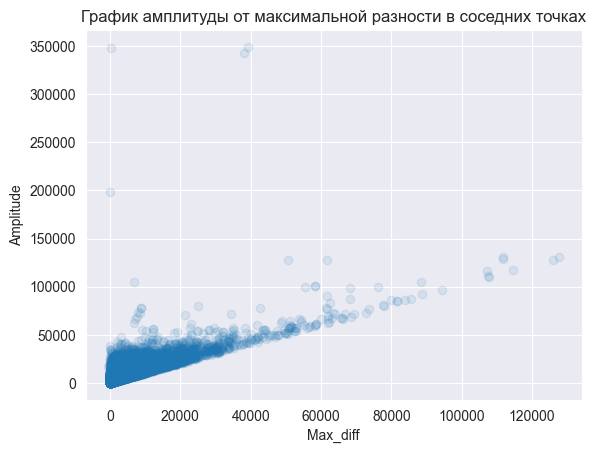

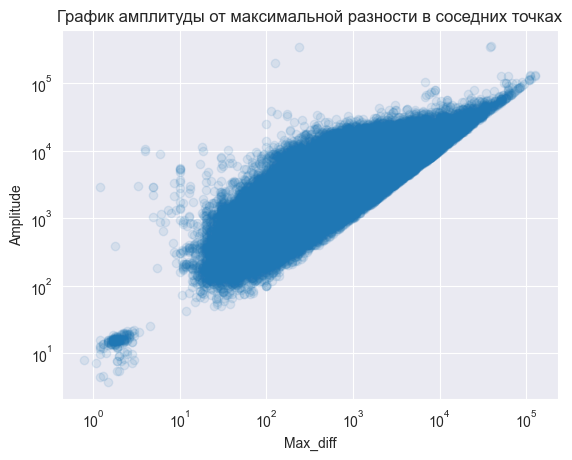

In [7]:
plt.scatter(df_res["max_diff"], df_res["amplitude"], alpha= 0.1)

plt.ylabel('Amplitude')
plt.xlabel('Max_diff')
plt.title('График амплитуды от максимальной разности в соседних точках')
# Отображение графика
plt.show()

plt.scatter(df_res["max_diff"], df_res["amplitude"], alpha= 0.1)

plt.ylabel('Amplitude')
plt.xlabel('Max_diff')
plt.title('График амплитуды от максимальной разности в соседних точках')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

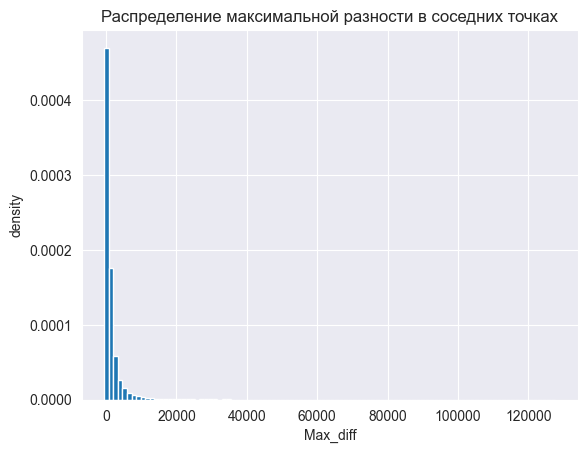

In [11]:
plt.hist(df_res["max_diff"], density=True, bins=100)

plt.ylabel("density")
plt.xlabel('Max_diff')
plt.title('Распределение максимальной разности в соседних точках')
# Отображение графика
plt.show()

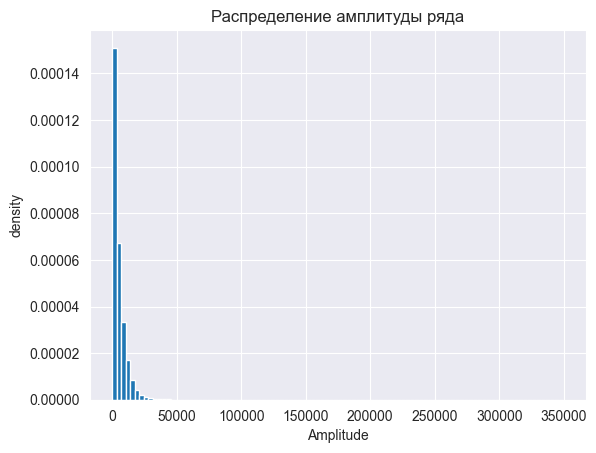

In [12]:
plt.hist(df_res["amplitude"], density=True, bins=100)

plt.ylabel("density")
plt.xlabel('Amplitude')
plt.title('Распределение амплитуды ряда')
# Отображение графика
plt.show()

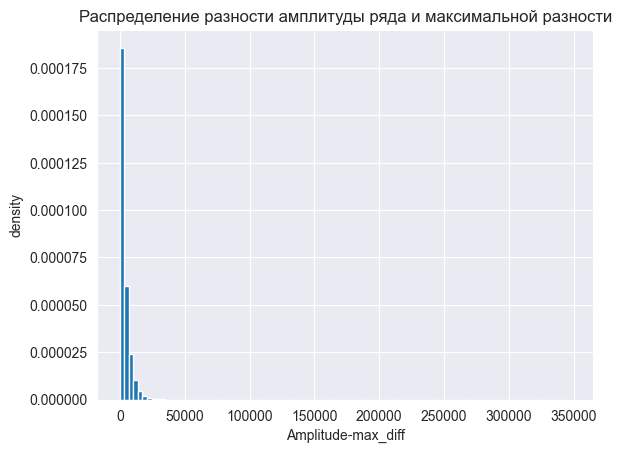

In [39]:
plt.hist(df_res["amplitude"]-df_res["max_diff"], density=True, bins=100)

plt.ylabel("density")
plt.xlabel('Amplitude-max_diff')
plt.title('Распределение разности амплитуды ряда и максимальной разности')

# Отображение графика
plt.show()

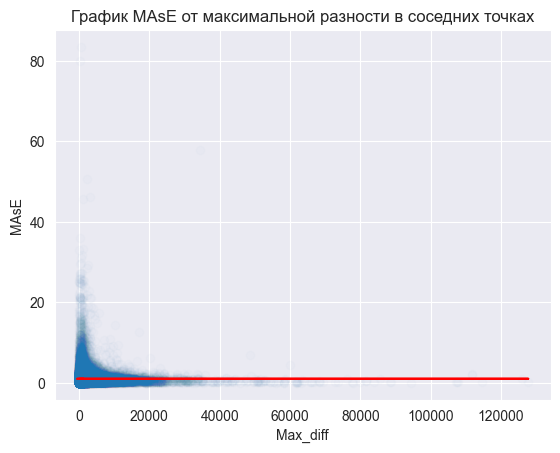

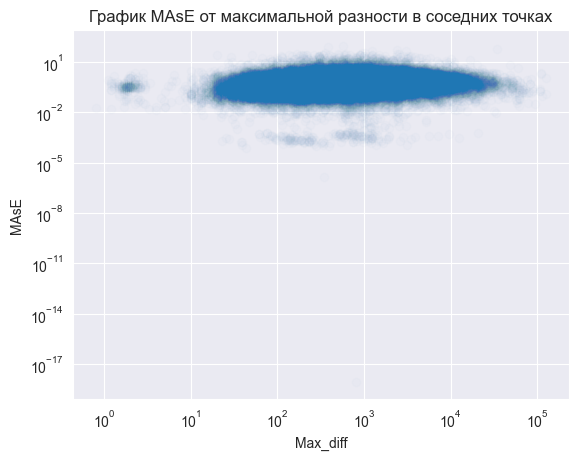

In [10]:
plt.scatter(df_res["max_diff"], df_res["mase"], alpha=0.01)
plt.plot(df_res["max_diff"], [1]*df_res["max_diff"].shape[0], color="red")
plt.ylabel('MAsE')
plt.xlabel('Max_diff')
plt.title('График MAsE от максимальной разности в соседних точках')
# Отображение графика
plt.show()

plt.scatter(df_res["max_diff"], df_res["mase"], alpha=0.01)

plt.ylabel('MAsE')
plt.xlabel('Max_diff')
plt.title('График MAsE от максимальной разности в соседних точках')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

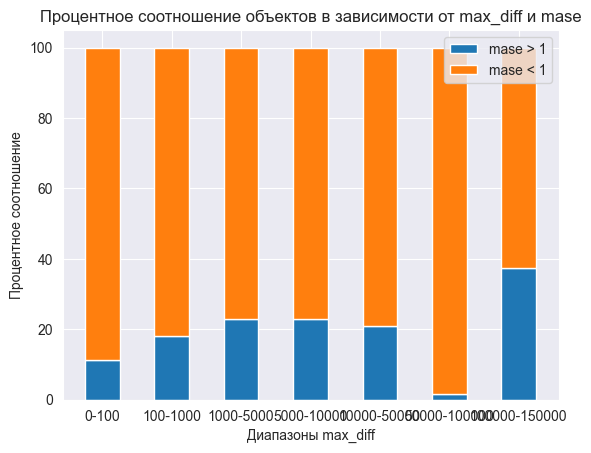

In [20]:
mase_gt_1_percentages = []
mase_lt_1_percentages = []

bins = [0, 100, 1000, 5000, 10000, 50000, 100000,150000]
for i in range(len(bins) - 1):
    mask = (df_res['max_diff'] >= bins[i]) & (df_res['max_diff'] < bins[i+1])
    total_count = mask.sum()
    mase_gt_1_count = (df_res[mask & (df_res['mase'] > 1)]['max_diff']).count()
    mase_lt_1_count = (df_res[mask & (df_res['mase'] < 1)]['max_diff']).count()
    mase_gt_1_percent = (mase_gt_1_count / total_count) * 100 if total_count != 0 else 0
    mase_lt_1_percent = (mase_lt_1_count / total_count) * 100 if total_count != 0 else 0
    mase_gt_1_percentages.append(mase_gt_1_percent)
    mase_lt_1_percentages.append(mase_lt_1_percent)


width = 0.5
x = range(len(bins) - 1)
fig, ax = plt.subplots()
rects1 = ax.bar(x, mase_gt_1_percentages, width, label='mase > 1')
rects2 = ax.bar(x, mase_lt_1_percentages, width, label='mase < 1', bottom=mase_gt_1_percentages)


ax.set_ylabel('Процентное соотношение')
ax.set_xlabel('Диапазоны max_diff')
ax.set_title('Процентное соотношение объектов в зависимости от max_diff и mase')
ax.set_xticks(x)
ax.set_xticklabels([f'{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)])
ax.legend()

plt.show()

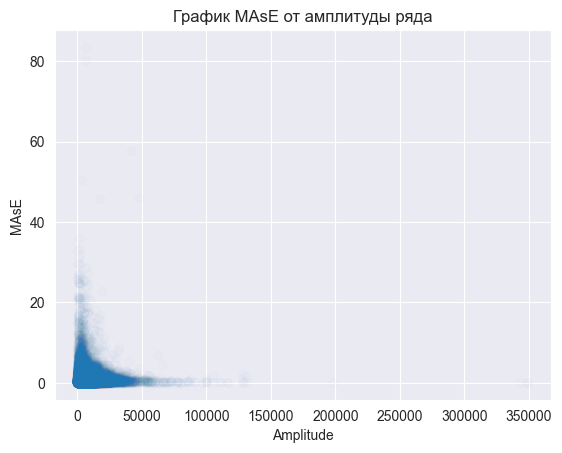

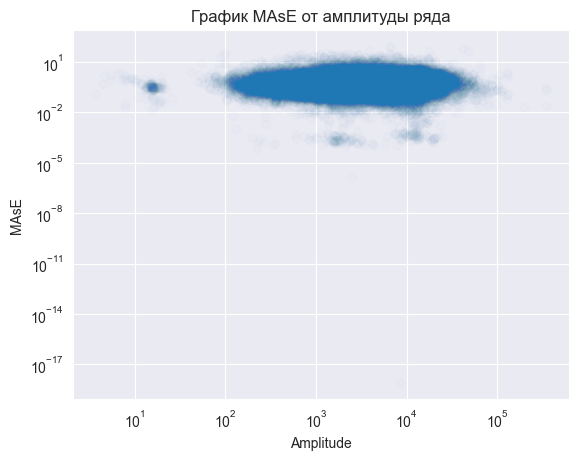

In [21]:
plt.scatter(df_res["amplitude"], df_res["mase"], alpha=0.01)

plt.ylabel('MAsE')
plt.xlabel('Amplitude')
plt.title('График MAsE от амплитуды ряда')
# Отображение графика
plt.show()

plt.scatter(df_res["amplitude"], df_res["mase"], alpha=0.01)

plt.ylabel('MAsE')
plt.xlabel('Amplitude')
plt.title('График MAsE от амплитуды ряда')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

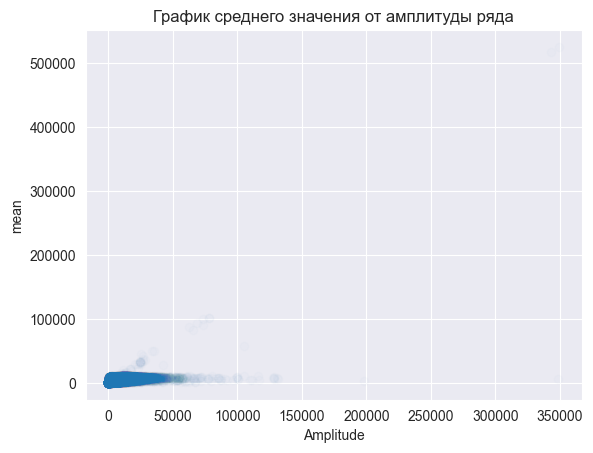

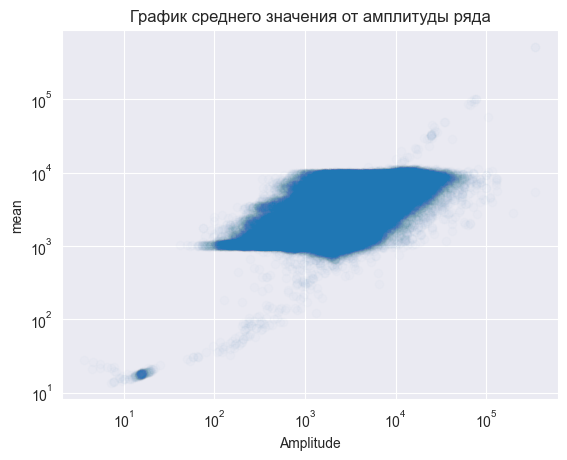

In [22]:
plt.scatter(df_res["amplitude"], df_res["mean"], alpha=0.01)

plt.ylabel('mean')
plt.xlabel('Amplitude')
plt.title('График среднего значения от амплитуды ряда')
# Отображение графика
plt.show()

plt.scatter(df_res["amplitude"], df_res["mean"], alpha=0.01)

plt.ylabel('mean')
plt.xlabel('Amplitude')
plt.title('График среднего значения от амплитуды ряда')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

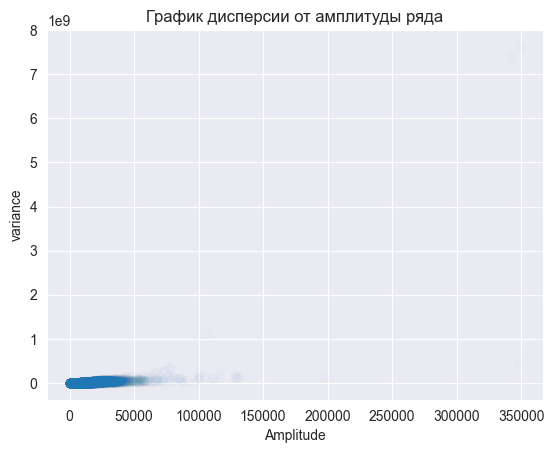

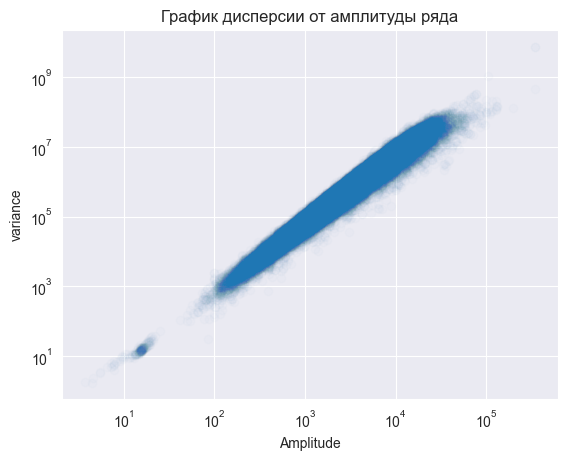

In [23]:
plt.scatter(df_res["amplitude"], df_res["variance"], alpha=0.01)

plt.ylabel('variance')
plt.xlabel('Amplitude')
plt.title('График дисперсии от амплитуды ряда')
# Отображение графика
plt.show()

plt.scatter(df_res["amplitude"], df_res["variance"], alpha=0.01)

plt.ylabel('variance')
plt.xlabel('Amplitude')
plt.title('График дисперсии от амплитуды ряда')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

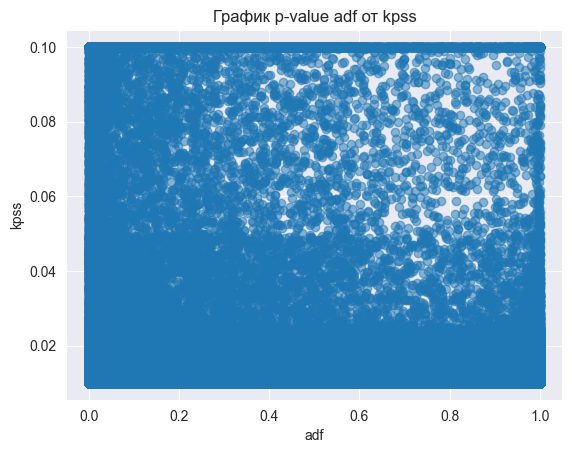

In [28]:
plt.show()
plt.scatter(df_res["adf_test_pvalue"], df_res["kpss_test_pvalue"], alpha=0.5)

plt.ylabel('kpss')
plt.xlabel('adf')
plt.title('График p-value adf от kpss')
# Отображение графика
plt.show()

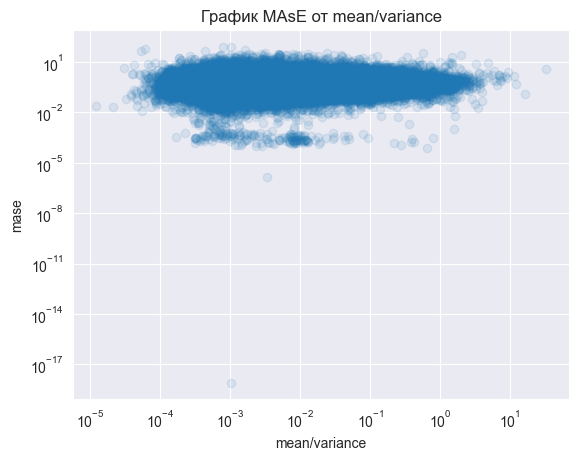

In [35]:
plt.scatter(df_res["mean"]/df_res["variance"], df_res["mase"], alpha=0.1)

plt.xlabel('mean/variance')
plt.ylabel('mase')
plt.title('График MAsE от mean/variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

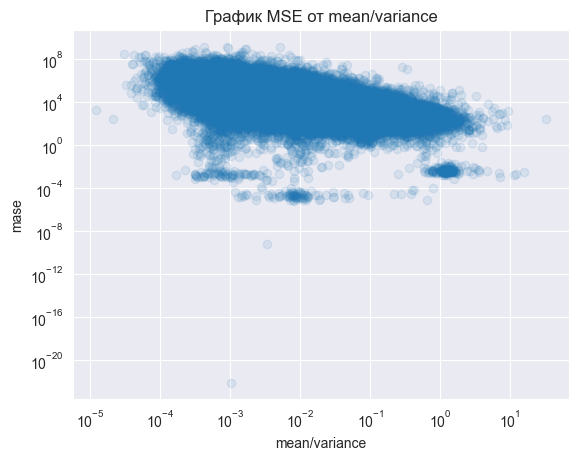

In [44]:
plt.scatter(df_res["mean"]/df_res["variance"], df_res["mse"], alpha=0.1)

plt.xlabel('mean/variance')
plt.ylabel('mase')
plt.title('График MSE от mean/variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

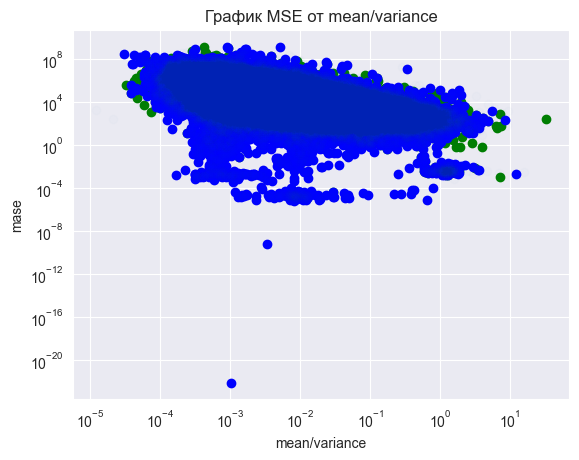

In [43]:
plt.scatter(df_res.loc[df_res["adf_test_pvalue"]<0.05]["mean"] / df_res.loc[df_res["adf_test_pvalue"]<0.05]["variance"], df_res.loc[df_res["adf_test_pvalue"]<0.05]["mse"], color="green")
plt.scatter(df_res.loc[df_res["kpss_test_pvalue"]<0.05]["mean"] / df_res.loc[df_res["kpss_test_pvalue"]<0.05]["variance"], df_res.loc[df_res["kpss_test_pvalue"]<0.05]["mse"], color="blue")
plt.scatter(df_res["mean"]/df_res["variance"], df_res["mse"], alpha=0.01)
plt.xlabel('mean/variance')
plt.ylabel('mase')
plt.title('График MSE от mean/variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

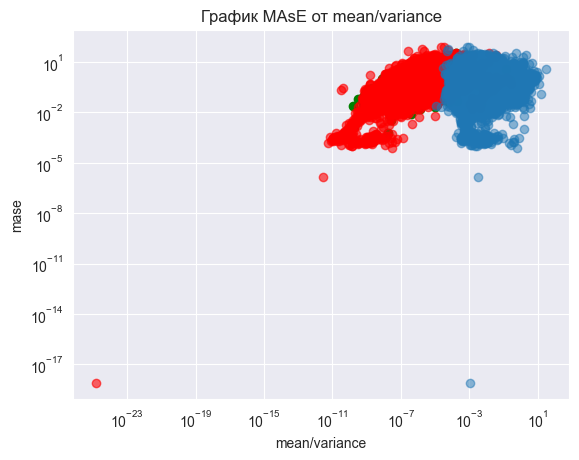

In [53]:
plt.scatter(
    df_res.loc[df_res["adf_test_pvalue"] < 0.05]["mase"] / df_res.loc[df_res["adf_test_pvalue"] < 0.05]["variance"],
    df_res.loc[df_res["adf_test_pvalue"] < 0.05]["mase"], color="green")
plt.scatter(
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["mase"] / df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["variance"],
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["mase"], color="red", alpha=0.6)
plt.scatter(df_res["mean"] / df_res["variance"], df_res["mase"], alpha=0.5)
plt.xlabel('mean/variance')
plt.ylabel('mase')
plt.title('График MAsE от mean/variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

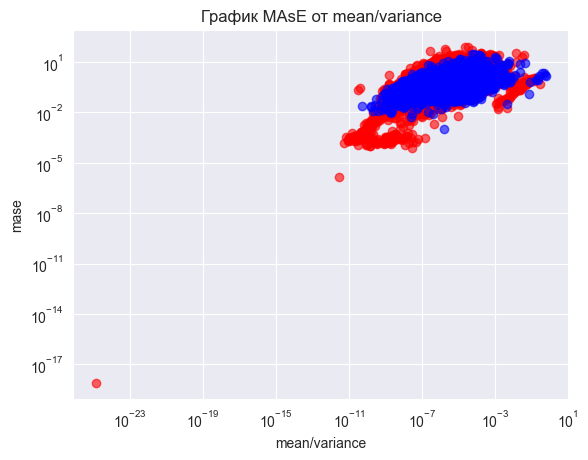

In [56]:
plt.scatter(
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["mase"] / df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["variance"],
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["mase"], color="red", alpha=0.6)
plt.scatter(
    df_res.loc[df_res["kpss_test_pvalue"] >= 0.1]["mase"] / df_res.loc[df_res["kpss_test_pvalue"] >= 0.1]["variance"],
    df_res.loc[df_res["kpss_test_pvalue"] >= 0.1]["mase"], color="blue", alpha=0.6)
plt.xlabel('mean/variance')
plt.ylabel('mase')
plt.title('График MAsE от mean/variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

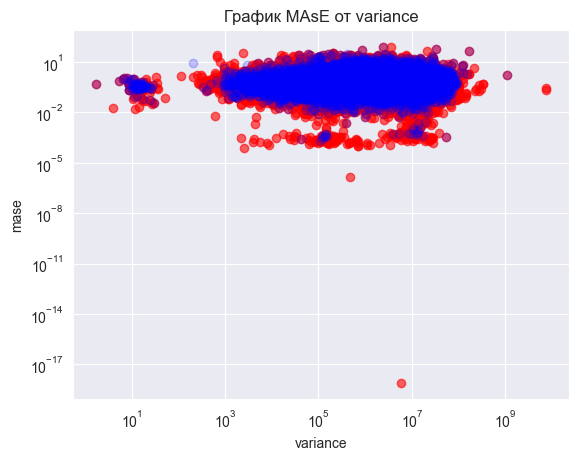

In [65]:
plt.scatter(
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["variance"],
    df_res.loc[df_res["kpss_test_pvalue"] < 0.05]["mase"], color="red", alpha=0.6)
plt.scatter(
    df_res.loc[df_res["adf_test_pvalue"] >= 0.9]["variance"],
    df_res.loc[df_res["adf_test_pvalue"] >= 0.9]["mase"], color="blue", alpha=0.2)
plt.xlabel('variance')
plt.ylabel('mase')
plt.title('График MAsE от variance')
plt.semilogy()
plt.semilogx()
# Отображение графика
plt.show()

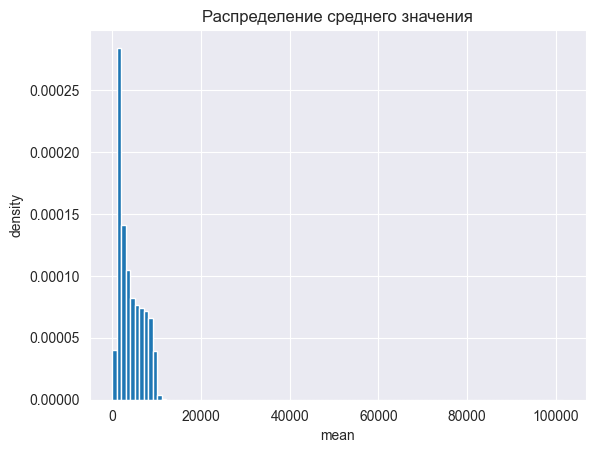

In [75]:
plt.hist(df_res[df_res["mean"]<=200000]["mean"], bins=100, density=True)

plt.ylabel("density")
plt.xlabel('mean')
plt.title('Распределение среднего значения')
# Отображение графика
plt.show()

In [72]:
df_res[df_res["mean"]>200000]

,V1,perm_ent3,perm_ent4,mse,mape,sym_test,w_perm_ent4,smape,mase,max_diff,amplitude,mean,variance,adf_test_pvalue,kpss_test_pvalue
56,H57,NaN,0.426391,4.904619e+07,0.010650,False,0.257703,0.010602,0.303673,39345.0,349457.0,524855.040000,7.620296e+09,0.825768,0.01
120,H121,NaN,0.427705,3.038963e+07,0.007581,False,0.256800,0.007565,0.228306,38073.0,343158.0,516871.464286,7.409161e+09,0.895472,0.01


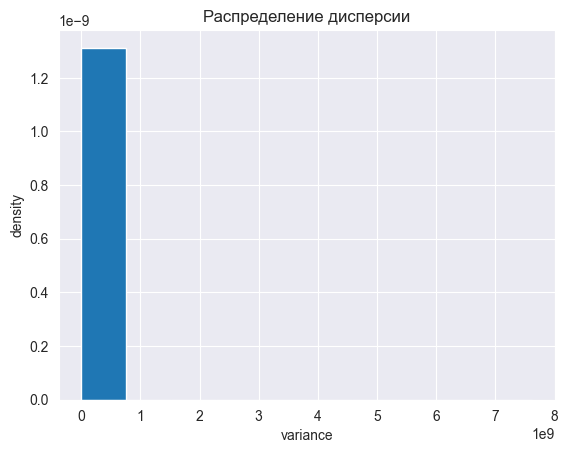

In [77]:
plt.hist(df_res["variance"], density=True)

plt.ylabel("density")
plt.xlabel('variance')
plt.title('Распределение дисперсии')
# Отображение графика
plt.show()

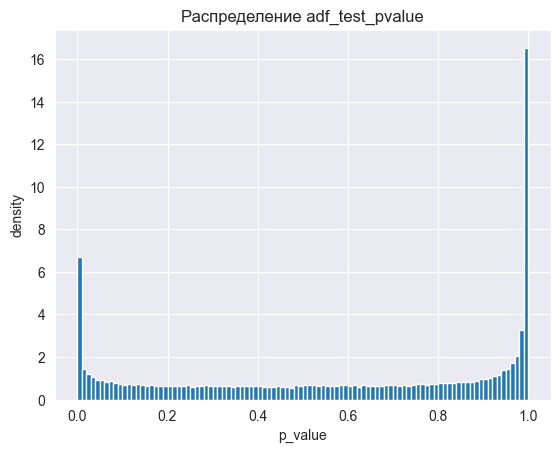

In [78]:
plt.hist(df_res["adf_test_pvalue"], density=True, bins=100)

plt.ylabel("density")
plt.xlabel('p_value')
plt.title('Распределение adf_test_pvalue')
# Отображение графика
plt.show()

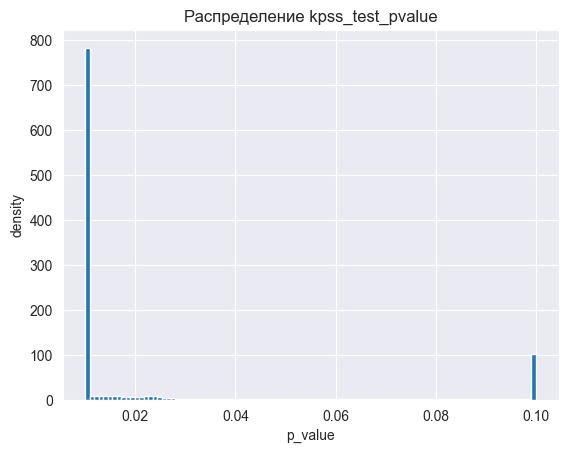

In [79]:
plt.hist(df_res["kpss_test_pvalue"], density=True, bins=100)

plt.ylabel("density")
plt.xlabel('p_value')
plt.title('Распределение kpss_test_pvalue')
# Отображение графика
plt.show()

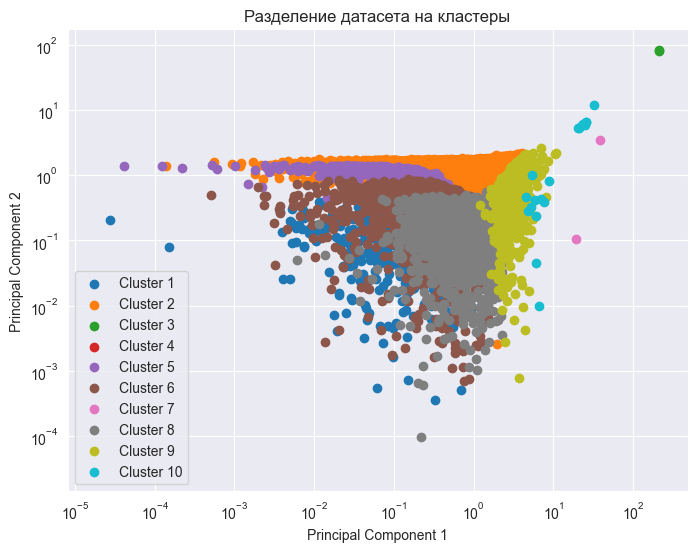

In [59]:
kmeans = KMeans(n_clusters=10, random_state=42)
X = df_res[["mean","adf_test_pvalue", "variance", "sym_test", "max_diff", "amplitude"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
plt.figure(figsize=(8, 6))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
for i in range(10):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')

plt.title('Разделение датасета на кластеры')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

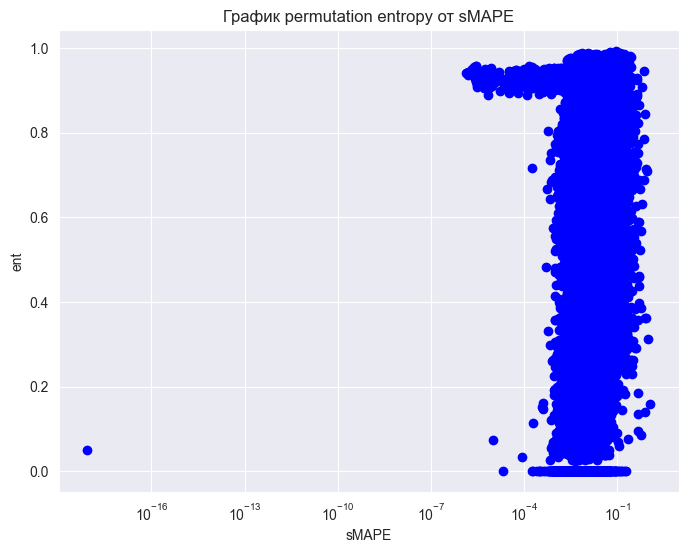

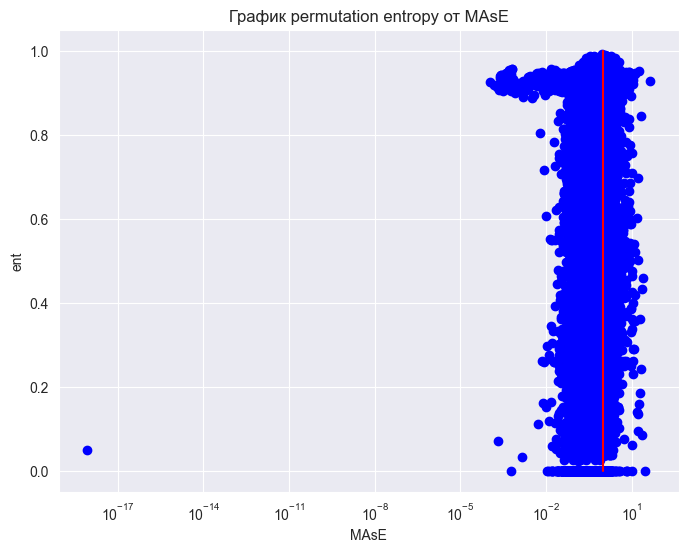

In [61]:
df_cl1 = df_res[cluster_labels == 1]
symmetry_ts = df_cl1.loc[df_cl1['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl1['smape'], df_cl1["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl1['mase'], df_cl1["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.plot([1]*11, [0.1*i for i in range(11)], color="red")
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

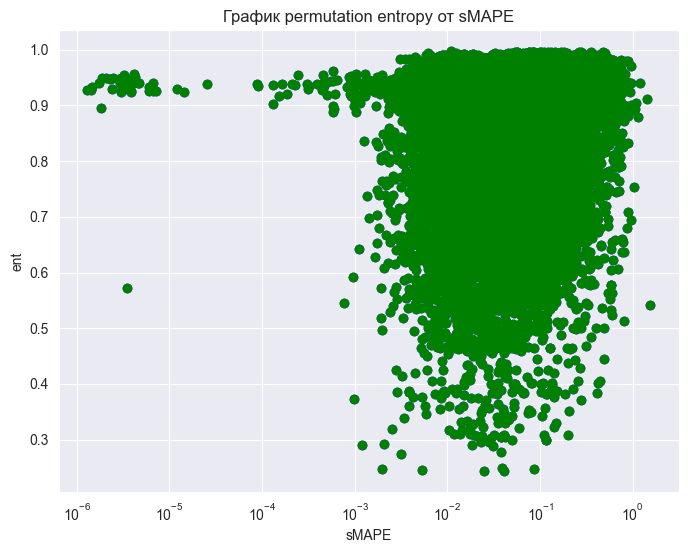

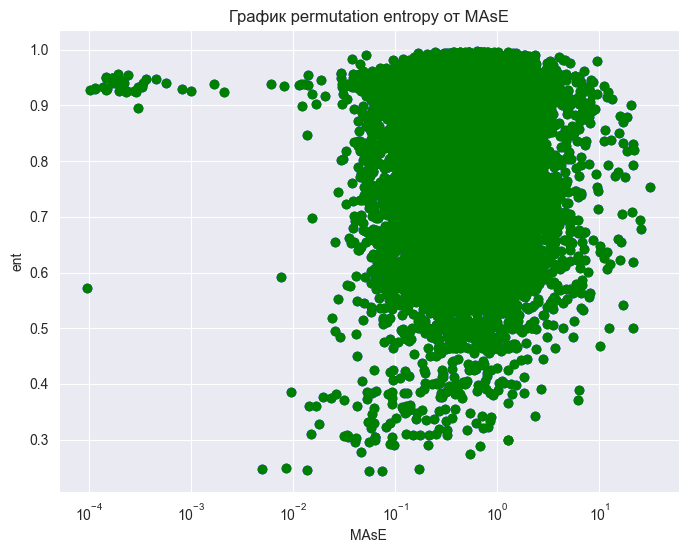

In [63]:
df_cl3 = df_res[cluster_labels == 3]
symmetry_ts = df_cl3.loc[df_cl3['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl3['smape'], df_cl3["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl3['mase'], df_cl3["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

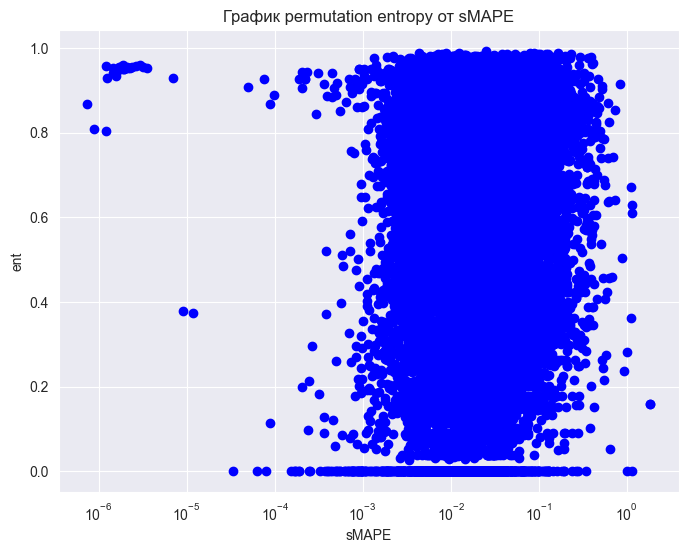

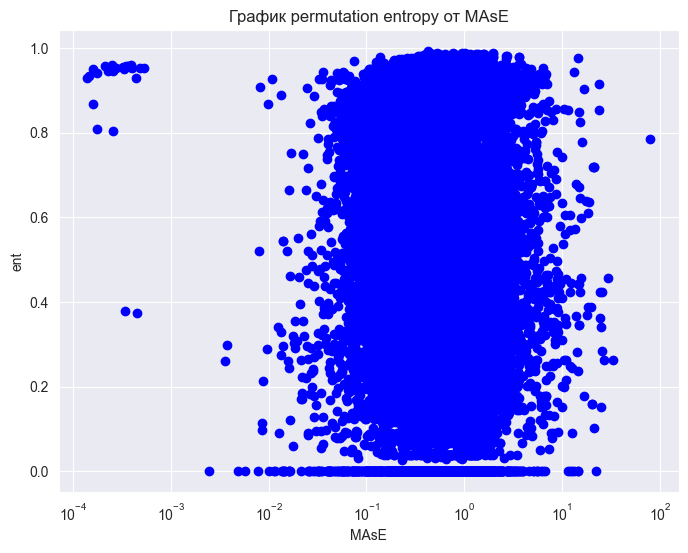

In [67]:
df_cl4 = df_res[cluster_labels == 4]
symmetry_ts = df_cl4.loc[df_cl4['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl4['smape'], df_cl4["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl4['mase'], df_cl4["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

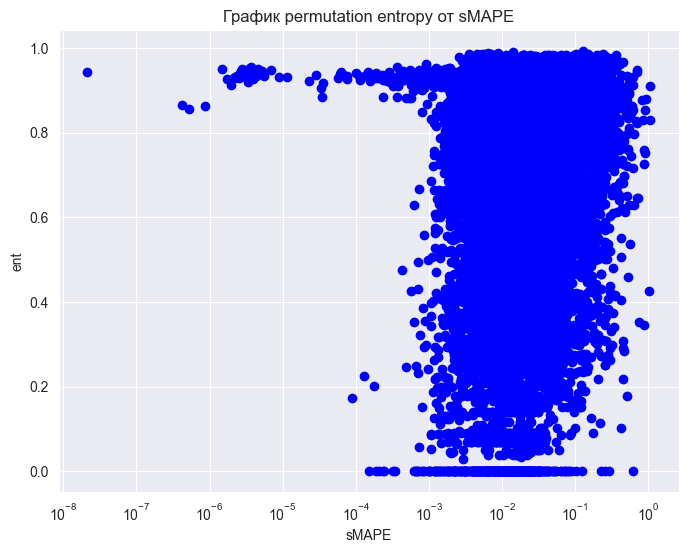

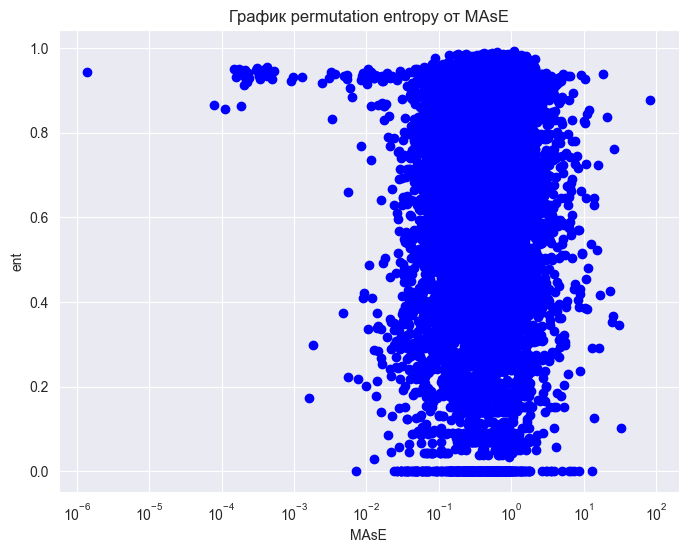

In [66]:
df_cl5 = df_res[cluster_labels == 5]
symmetry_ts = df_cl5.loc[df_cl5['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl5['smape'], df_cl5["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl5['mase'], df_cl5["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

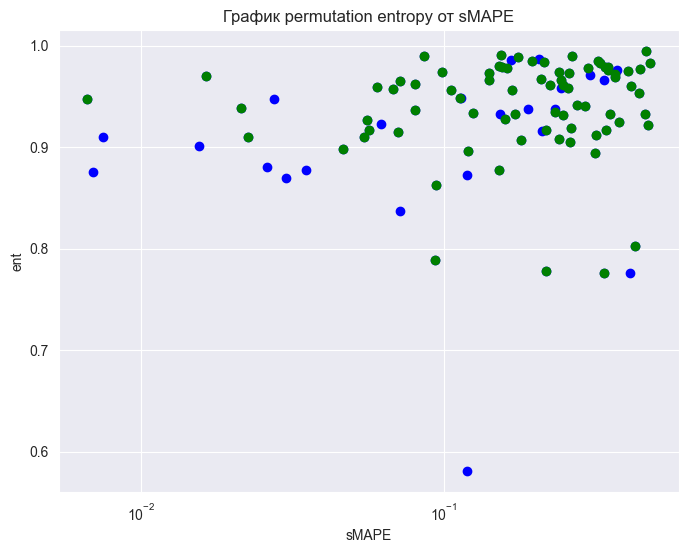

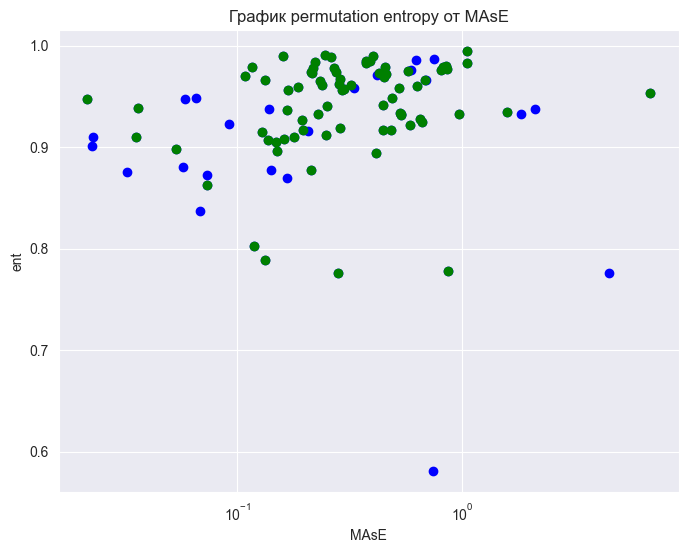

In [68]:
df_cl6 = df_res[cluster_labels == 6]
symmetry_ts = df_cl6.loc[df_cl6['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl6['smape'], df_cl6["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl6['mase'], df_cl6["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

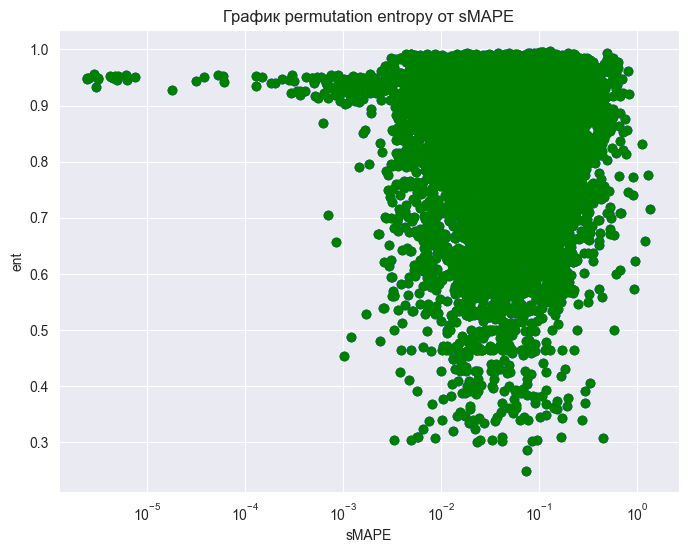

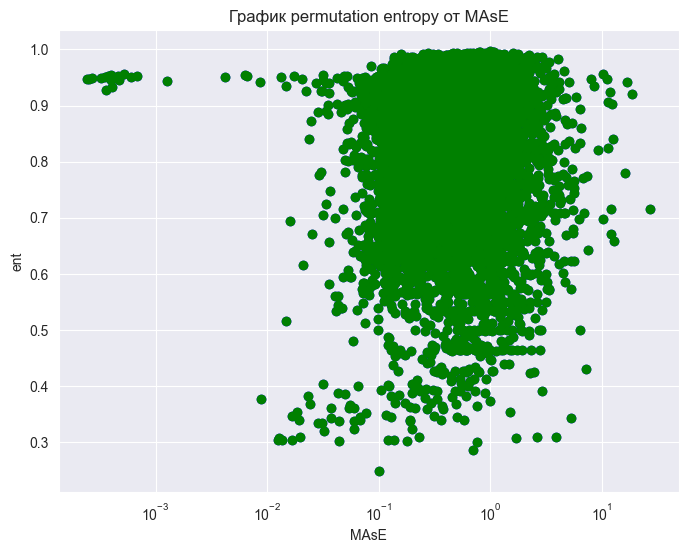

In [69]:
df_cl7 = df_res[cluster_labels == 7]
symmetry_ts = df_cl7.loc[df_cl7['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl7['smape'], df_cl7["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl7['mase'], df_cl7["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

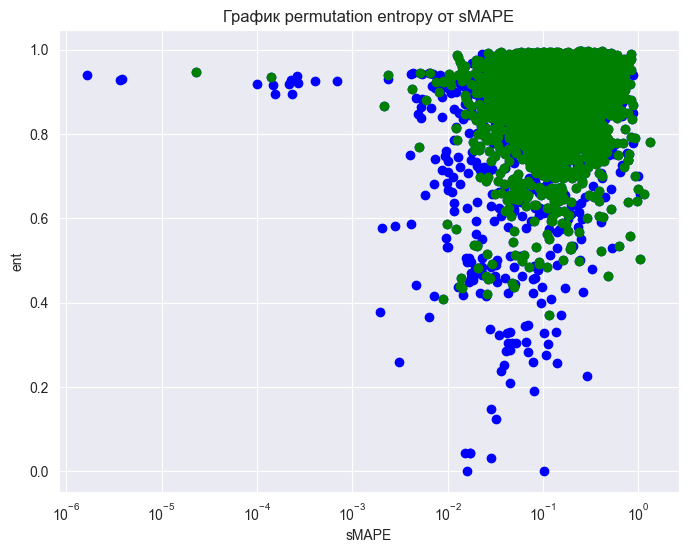

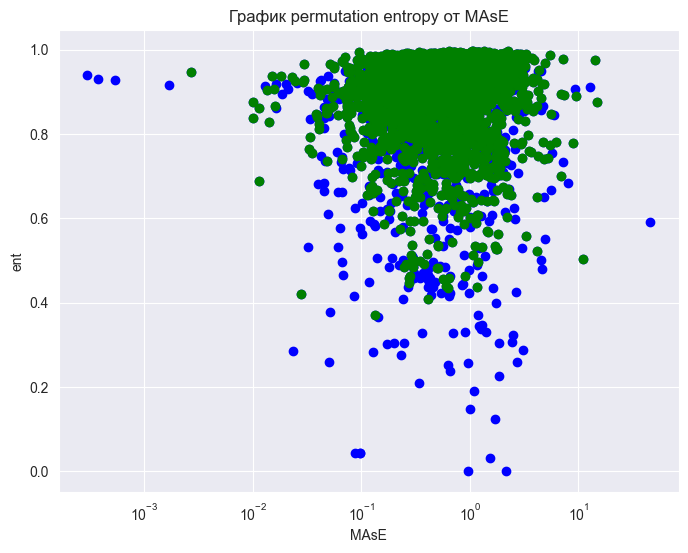

In [70]:
df_cl8 = df_res[cluster_labels == 8]
symmetry_ts = df_cl8.loc[df_cl8['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl8['smape'], df_cl8["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl8['mase'], df_cl8["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

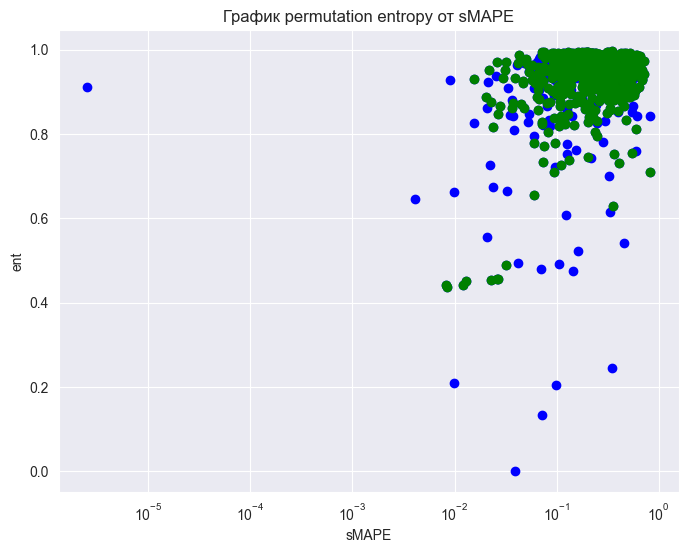

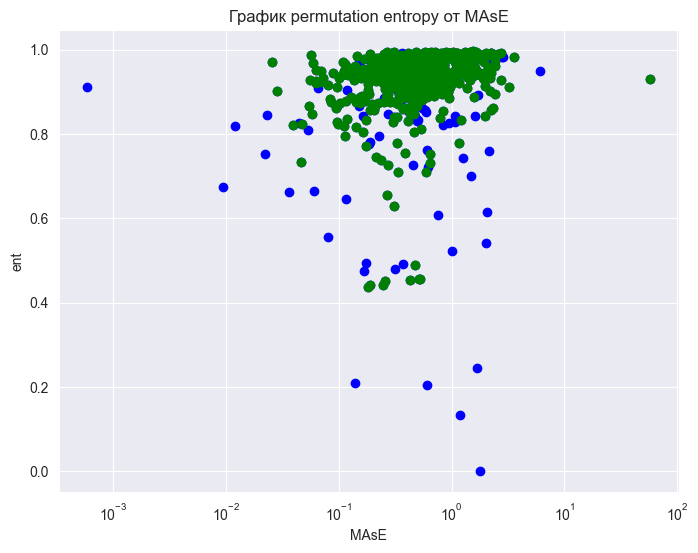

In [71]:
df_cl9 = df_res[cluster_labels == 9]
symmetry_ts = df_cl9.loc[df_cl9['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl9['smape'], df_cl9["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl9['mase'], df_cl9["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()

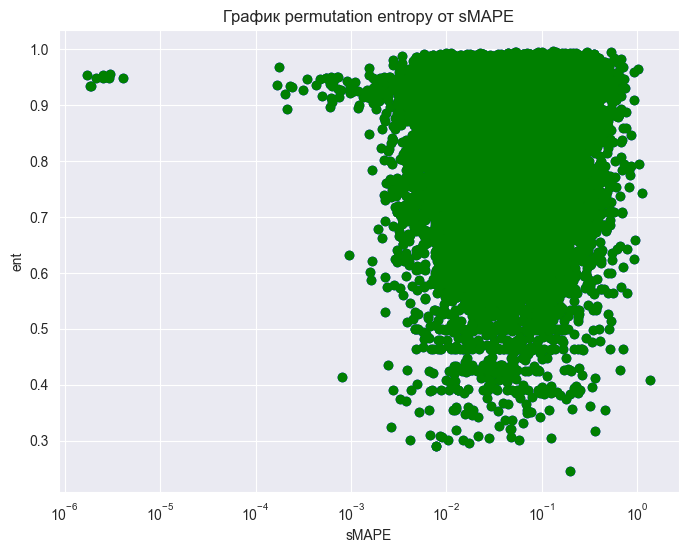

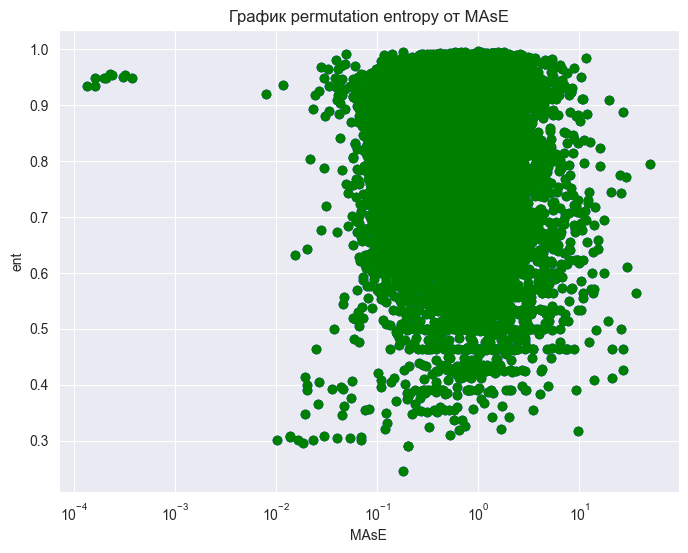

In [73]:
df_cl0 = df_res[cluster_labels == 0]
symmetry_ts = df_cl0.loc[df_cl0['sym_test']]

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl0['smape'], df_cl0["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['smape'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('ent')
plt.grid(True)
plt.show()
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_cl0['mase'], df_cl0["perm_ent4"], color='blue')
plt.scatter(symmetry_ts['mase'], symmetry_ts['perm_ent4'], color='green', label='Highlight')
plt.semilogx()
plt.title('График permutation entropy от MAsE')
plt.xlabel('MAsE')
plt.ylabel('ent')
plt.grid(True)
plt.show()